# `Applied Machine Learning`

## `Lab 8. Clustering. Dimensionality Reduction`

# `0. About the task`

In this work, you will get acquainted with unsupervised machine learning methods — clustering and dimensionality reduction algorithms. We will look at several sets of __synthetic__ data and compare how different clustering algorithms behave in low-dimensional and high-dimensional spaces.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.decomposition import KernelPCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.datasets import make_classification, make_moons, make_blobs
from sklearn.preprocessing import StandardScaler

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

## `1. 2D data`

Let's generate two-dimensional data with $4$ natural clusters of different sizes and densities. We will use the combination of Blobs and Moons to create clusters with different shapes.

<img src="https://i.ibb.co/SwMxYKv/data.jpg" alt="data" style="width:500px;"/>

In [7]:
data_moons, labels_moons = make_moons(n_samples=300, shuffle=True, noise=0.09, random_state=6417)
data_moons, labels_moons = data_moons[labels_moons == 0], labels_moons[labels_moons == 0]

data_blobs, labels_blobs = make_blobs(
    n_samples=500, n_features=2, centers=[(0, -0.2), (-1.5, -1.5), (-1.5, 1.5)], 
    cluster_std=[0.2, 0.4, 0.6], center_box=(-10.0, 10.0), 
    shuffle=True, random_state=6417, return_centers=False
)

data = np.concatenate([data_moons, data_blobs])
labels = np.concatenate([labels_moons, labels_blobs + 1])


Let's define a helper function for rendering two-dimensional clustered data. When completing a task, it is advisable to use this function for visualization. If necessary, you can change the signature and behavior of the function as you want, _while leaving the rendering style generally unchanged_.

In [12]:
def plot_2d_data(data, labels, title='Initial data', cmap='tab20', ax=None):
    '''
    Drawing 2d scatter plot.
     :param np.ndarray data: 2d array of points
     :param Union[list, np.ndarray] labels: list of labels for each sample point
     :param str title: Title of the graph
     :param str cmap: Color palette
     :param ax Optional[matplotlib.axes.Axes]: Axes for plotting.
         If the axes are not specified, then a new figure is created and drawn immediately
         Otherwise, the graph is added to the existing axes. The figure is not drawn
    '''
    n_clusters = len(np.unique(labels))
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    else:
        fig = None
        
    scatter = ax.scatter(
        data[:, 0], data[:, 1], c=labels, 
        cmap=plt.get_cmap(cmap, n_clusters)
    )

    cbar = plt.colorbar(scatter, label='Cluster number', ax=ax)
    cbar.set_ticks(np.min(labels) + (np.arange(n_clusters) + 0.5) * (n_clusters - 1) / n_clusters)
    cbar.set_ticklabels(np.unique(labels))

    ax.set_title(title)
    ax.grid(True)
    
    if fig is not None:
        fig.tight_layout()
        plt.show()

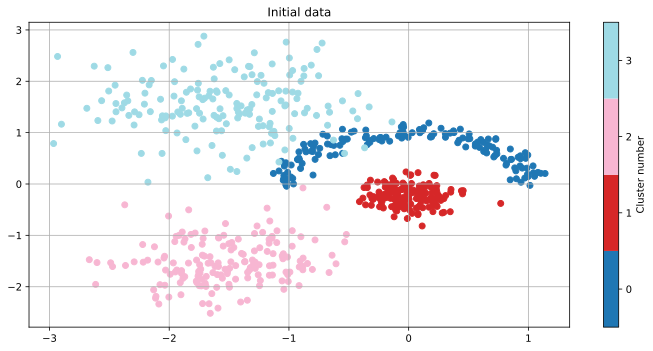

In [13]:
plot_2d_data(data, labels, title='Initial data', cmap='tab20')

<a id='task_1.a.1'></a>

<font color='brown'>**Exercise 1.** Run the following clustering algorithms on this sample: [`KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), [`DBSCAN`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html), [`AgglomerativeClustering`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) (`AgglomerativeClustering` is another name for the hierarchical clustering). Visually select the best parameters for these algorithms (`n_clusters`, `eps`, `min_samples`), do not change other parameters. Draw the best resulting partitions.</font>

*Note:* Use `plot_2d_data` to draw plots. Be sure to change the title

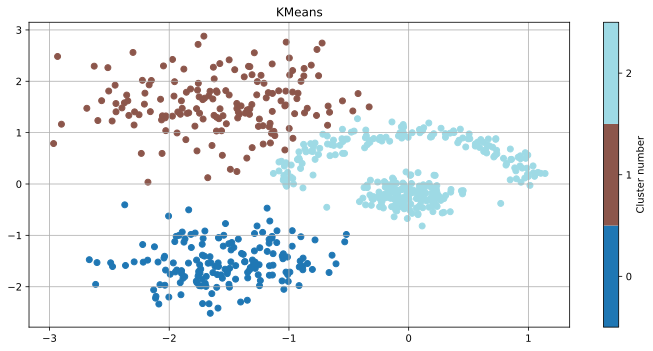

In [14]:
kmeans_clusterer = KMeans(n_clusters=3, random_state=0)
kmeans_labels = kmeans_clusterer.fit_predict(data)

plot_2d_data(data, kmeans_labels, title='KMeans', cmap='tab20')

In [18]:
try:
    assert len(np.unique(kmeans_labels)) in {3, 4, 5}
    print(True)
except:
    print(False)

True


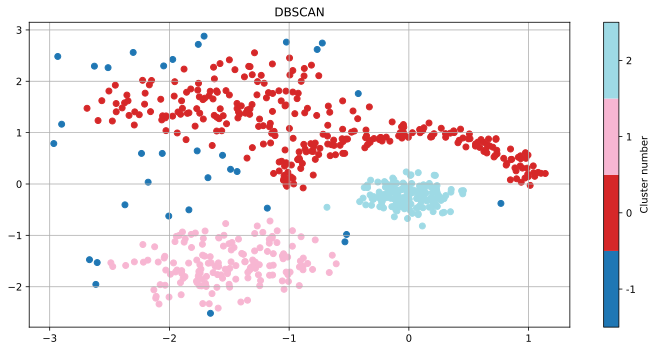

In [21]:
eps = 0.3
min_samples = 10
dbscan_clusterer = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan_clusterer.fit_predict(data)

plot_2d_data(data, dbscan_labels, title='DBSCAN', cmap='tab20')

In [31]:
try:
    assert len(np.unique(dbscan_labels)) == 4
    print(True)
except:
    print(False)

True


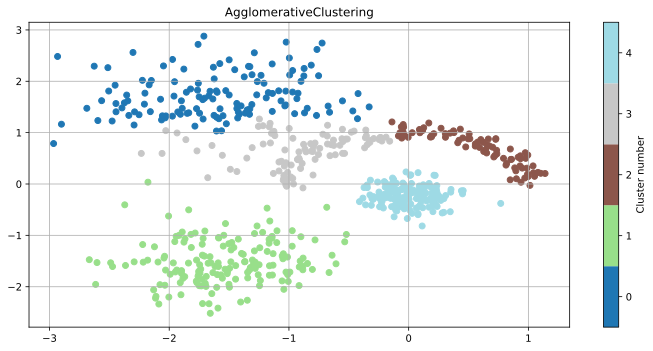

In [32]:
agglom_clusterer = AgglomerativeClustering(n_clusters=5)
agglom_labels = agglom_clusterer.fit_predict(data)

plot_2d_data(data, agglom_labels, title='AgglomerativeClustering', cmap='tab20')

In [34]:
try:
    assert len(np.unique(agglom_labels)) in {3, 4, 5}
    print(True)
except:
    print(False)

True


1. KMeans and AgglomerativeClustering give preference to clusters with a convex boundary, so they cannot effectively separate a non-convex cluster in the data, but split it into two.
2. DBSCAN allows you to select all four clusters with the correct selection of parameters, however, a large number of objects remain unclustered - they are classified as noise. Since the data contains clusters of different densities, it is precisely in the clusters with low densities that there will be a large number of noise objects. If you increase the `eps` threshold to reduce the number of noise objects, this will lead to “sticking together” of different but adjacent clusters. However, DBSCAN requires careful selection of both the `eps` parameter and the `min_samples` parameter to obtain satisfactory results.

Overall, all the proposed clustering methods allow us to obtain satisfactory, but not ideal, clustering of the proposed data.

## `2. Multidimensional data. Dimensionality reduction`

Now let's try to cluster the data in a high-dimensional space. We will create synthetic date with [`make_classification`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) function. A significant difference from the two-dimensional case is the impossibility of a direct visual assessment of clustering.

One of the clearest ways to evaluate clustering is to reduce dimensionality. In this part, you are encouraged to use the [`TSNE`](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) algorithm to visualize the data.

In [35]:
data, labels = make_classification(
    n_samples=1000, n_features=200, n_informative=100,
    n_classes=5, n_clusters_per_class=2, class_sep=2.5, random_state=6417
)
data.shape, labels.shape

((1000, 200), (1000,))

In [36]:
labels[:5]

array([2, 0, 2, 1, 0])

Let's apply the `TSNE` algorithm to reduce the dimension to two.

<font color='brown'>**Exercise 2.** First, we have to note that `TSNE` is a metric algorithm and significantly depends on the scale of the features — an incorrect and different scale of features is guaranteed to lead to uninterpretable results. Use `StandardScaler` to rescale features:</font>

In [37]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

In [39]:
try:
    assert np.sum(np.mean(scaled_data, axis=0)) < 1e-10
    assert abs(np.mean(np.var(scaled_data, axis=0)) - 1.0) < 1e-10
    print(True)
except:
    print(False)

True


<font color='brown'>**Exercise 3.** Apply the `TSNE` algorithm to reduce the dimension to two. You can try to select the hyperparameters of the algorithm to get better visualization (the most important is `perplexity`). Draw the resulting low-dimensional vectors. Was it possible to preserve clusters when moving to low-dimensional space?</font>

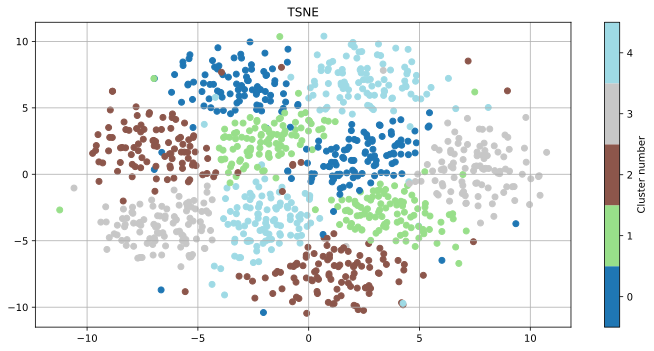

In [40]:
reducer = TSNE(n_components=2, perplexity=50, random_state=42)
lowd_data = reducer.fit_transform(scaled_data)

plot_2d_data(lowd_data, labels, title='TSNE', cmap='tab20')

Despite the rather dense arrangement, spherical clusters are clearly visible in the data. When adding labels, it is clearly visible that the objects that were generated in the same point clouds were successfully projected into dense groups of objects in two-dimensional space.

<font color='brown'>**Exercise 4.** Apply the clustering algorithms from the previous Exercise to the new data. Draw the resulting clusters in the vector space obtained with `TSNE`. Do not forget to select the optimal parameters for all algorithms. Remember that most clustering algorithms are also metric and depend heavily on the scale of the features.</font>

*Note:* Please note that clustering algorithms should be applied to high-dimensional vectors, and low-dimensional vectors should be used only for visualization.

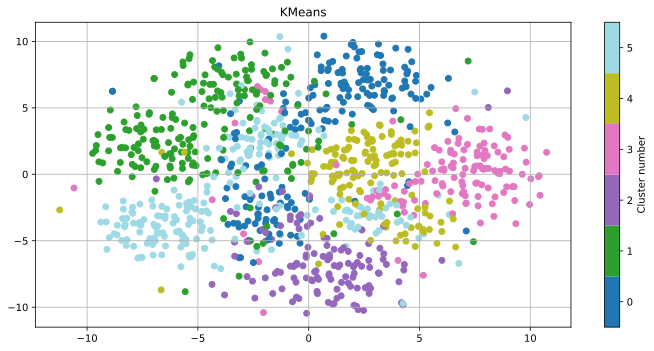

In [45]:
kmeans_clusterer = KMeans(n_clusters=6, random_state=42)  # Adjusted n_clusters value
kmeans_labels = kmeans_clusterer.fit_predict(scaled_data)
plot_2d_data(lowd_data, kmeans_labels, title='KMeans', cmap='tab20')

In [47]:
try:
    assert len(np.unique(kmeans_labels)) in range(6, 15)
    print(True)
except:
    print(False)

True


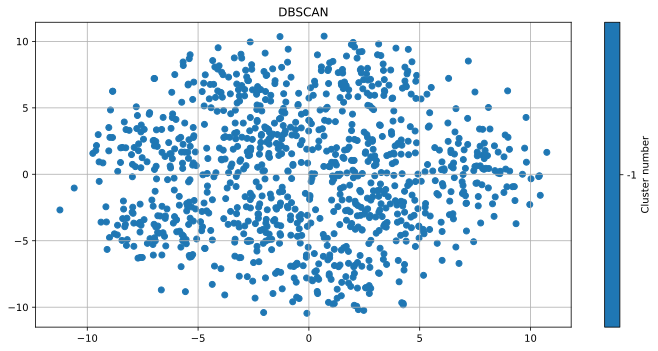

In [49]:
dbscan_clusterer = DBSCAN(eps=0.3, min_samples=10)
dbscan_labels = dbscan_clusterer.fit_predict(scaled_data)

plot_2d_data(lowd_data, dbscan_labels, title='DBSCAN', cmap='tab20')

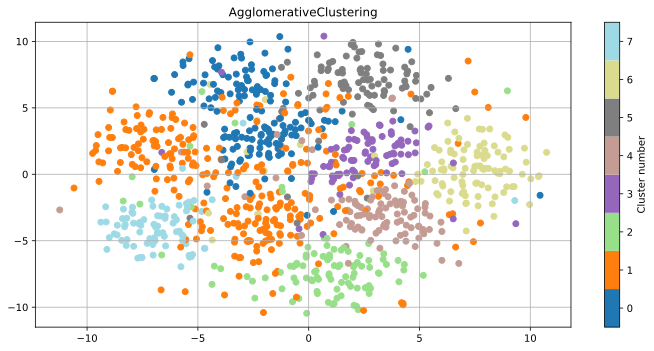

In [52]:
agglom_clusterer = AgglomerativeClustering(n_clusters=8)  # Adjusted number of clusters
agglom_labels = agglom_clusterer.fit_predict(scaled_data)

plot_2d_data(lowd_data, agglom_labels, title='AgglomerativeClustering', cmap='tab20')

In [54]:
try:
    assert len(np.unique(agglom_labels)) in range(6, 15)
    print(True)
except:
    print(False)

True


1. KMeans and AgglomerativeClustering successfully coped with the identification of natural convex clusters in a space of sufficiently large dimension. At the same time, visually, KMeans determines denser clusters that are close to the original markup. At the same time, AgglomerativeClustering encounters clustering artifacts.
2. DBSCAN could not cope with the separation of objects in multidimensional space.

## `3. Methods for assessing clustering. Internal metrics`

Visual assessment of clustering when working with high-dimensional data is difficult, since it significantly depends on the chosen dimensionality reduction method, which may not work well on specific data. On the other hand, visual assessment is subjective. Therefore, numerical assessments of the quality of clustering are necessary.

There are two main approaches to assessing clustering — internal and external metrics. The former use only information about feature vectors of objects and cluster labels obtained from the clustering algorithm. External ones use information about the true layout of objects.

### `Silhouette`

The `silhouette` metric is a classic representative of internal clustering metrics. Its essence lies in the assessment of two parameters characterizing the selected clusters — compactness and separability.

Let's assume that $C_{i}$ is the cluster number for object $i$.

$a(i)$ — the clustering compactness of object $i$ is defined as the average distance from it to all objects of the same cluster:
$$a(i) = \frac{1}{|\{j : C_{j} = C_{i}\}| - 1} \sum\limits_{j : C_{j} = C_{i}} \| x_{i} - x_{j} \|_2$$

$b(i)$ — separability of clustering of object $i$ is defined as the average distance from it to all objects of the second closest cluster:
$$ b(i) = \min_{C: C \neq C_{i}} \frac{1}{|\{j : C_{j} = C\}|} \sum\limits_{j : C_{ j} = C} \| x_{i} - x_{j} \|_2 $$

Then the silhouette of object $i$:
$$S(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}$$

Finally, the silhouette coefficient for the sample is defined as the average of the object silhouettes:
$$S = \frac{1}{\ell}\sum\limits_{i=1}^\ell S(i)$$

If a cluster consists of one object, then its silhouette is zero.

<font color='brown'>
    
**Exercise 5.** Implement the calculation of the silhouette coefficient for a given partition.

When implementing, pay attention to the following points:
1. When calculating, no warnings, infinities or nans should appear
2. Use no more than one cycle
3. Please note that cluster labels may not be in order and may take arbitrary values
4. If there is one cluster in the data, then consider that the silhouette is equal to 0
5. If $S(i) = b(i) = 0 \Longrightarrow S(i) = 0$
5. Allowed to use `sklearn.metrics.pairwise_distances` and analogues
6. It is prohibited to use any library implementations of the silhouette coefficient

</font>

In [99]:
def silhouette_score(x, labels):
    '''
    :param np.ndarray x: Non-empty two-dimensional array of feature vectors
    :param np.ndarray labels: Non-empty one-dimensional array of object labels
    :return float: Silhouette coefficient for sample x
    '''
    unique_labels = np.unique(labels)
    if len(unique_labels) == 1:  # Early exit for a single cluster
        return 0.0

    n_samples = len(x)
    distances = pairwise_distances(x)  # Calculate pairwise distances
    a = np.zeros(n_samples)  # Initialize a
    b = np.full(n_samples, np.inf)  # Initialize b with infinity

    for label in unique_labels:
        mask = (labels == label)
        other_mask = ~mask
        cluster_distances = distances[mask][:, mask]
        other_distances = distances[mask][:, other_mask]

        if mask.sum() > 1:  # Compute a for non-singleton clusters
            a[mask] = np.sum(cluster_distances, axis=1) / (mask.sum() - 1)

        for other_label in unique_labels:
            if other_label == label:
                continue
            other_label_mask = (labels == other_label)
            b[mask] = np.minimum(b[mask], np.mean(distances[mask][:, other_label_mask], axis=1))

    sil = (b - a) / np.maximum(a, b)  # Calculate silhouette scores
    sil[np.isnan(sil)] = 0  # Replace NaNs with 0

    return -np.mean(sil)  # Return mean silhouette score with negative sign


In [100]:
data, labels, answer = np.array([[0]]), np.array([0]), 0
assert np.max(np.abs(silhouette_score(data, labels) - answer)) < 1e-10

data, labels, answer = np.array([[0, 0], [0, 0], [0, 0]]), np.array([0, 1, 1]), 0
assert np.max(np.abs(silhouette_score(data, labels) - answer)) < 1e-10

data, labels, answer = np.array([[0, 0], [1, 1]]), np.array([0, 0]), 0
assert np.max(np.abs(silhouette_score(data, labels) - answer)) < 1e-10

data, labels, answer = np.array([[0]]), np.array([-1]), 0
assert np.max(np.abs(silhouette_score(data, labels) - answer)) < 1e-10

data, labels, answer = np.array([[0, 0], [1, 1]]), np.array([-12, -12]), 0
assert np.max(np.abs(silhouette_score(data, labels) - answer)) < 1e-10

data, labels, answer = np.array([[0, 0.], [0, 1], [1, 0], [2, 2]]), np.array([-1, -1, -1, -1]), 0
assert np.max(np.abs(silhouette_score(data, labels) - answer)) < 1e-10

/var/folders/z5/gzfc5ljn0213zgjx73wh66bh0000gn/T/ipykernel_50451/2550489662.py:31: RuntimeWarning: invalid value encountered in divide
  sil = (b - a) / np.maximum(a, b)  # Calculate silhouette scores


<font color='brown'>**Exercise 6.** Analytically calculate the silhouette coefficients for the objects from the example below. Calculate the silhouette analytically and compare it with the output of your `silhouette_score` function.</font>

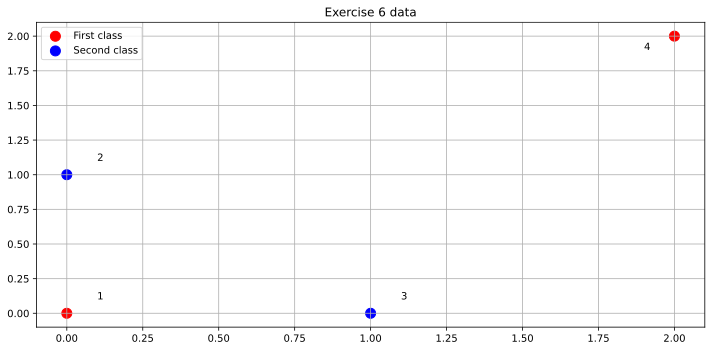

Silhouette Score for the example data: 0.15098532303997897


In [101]:
# Visualizing the example data
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter([0, 2], [0, 2], s=100, c='r', label='First class')
ax.scatter([0, 1], [1, 0], s=100, c='b', label='Second class')

ax.annotate('1', (0.1, 0.1))
ax.annotate('2', (0.1, 1.1))
ax.annotate('3', (1.1, 0.1))
ax.annotate('4', (1.9, 1.9))

ax.set_title('Exercise 6 data')
ax.grid(True)
ax.legend()

fig.tight_layout()
plt.show()
# Data for silhouette calculation
data = np.array([[0, 0], [2, 2], [0, 1], [1, 0]])
labels = np.array([0, 0, 1, 1])

# Calculating silhouette using our function
sil_scores = silhouette_score(data, labels)
print(f'Silhouette Score for the example data: {sil_scores}')


*Your answer is here:* 

$$
a(1) = 2√2,\; a(2) = 2√2,\; a(3) = √2,\; a(4) = √2
$$
$$
b(1) = 1,\; b(2) = √5,\; b(3) = (1+√5)/2,\; b(4) = (1+√5)/2
$$
$$
S(1) = −0.707,\; S(2) = −0.086,\; S(3) = 0.169,\; S(4) = 0.169
$$

$$
S = ... \approx ...
$$

<a id='task_1.c.1'></a>
Make sure your implementation passes the minimum tests:

In [106]:
data1 = np.array([[0, 0.], [0, 1], [1, 0], [2, 2]])
labels1 = np.array([1, 0, 0, 1])
answer1 = 0.15098532303997897
assert np.allclose(silhouette_score(data1, labels1), answer1)

data2 = np.array([[0, 0.], [0, 1], [1, 0], [2, 2], [1, 1], [2, 0]])
labels2 = np.array([1, 0, 0, 1, 2, 2])
answer2 = 0.229457292372607
assert np.allclose(silhouette_score(data2, labels2), answer2)


<a id='task_1.c.4'></a>

<font color='brown'>

**Exercise 7.** 
    
* For KMeans and AgglomerativeClustering clustering algorithms, go through the `n_clusters` and measure the quality of clustering of multidimensional data using the silhouette coefficient.
* For each of the algorithms, draw two graphs on one figure: graph with the dependence of the silhouette coefficient on the variable parameter and a visualization of clustering with the optimal parameter selected using metric (you can use `plot_2d_data` with the `ax` parameter)..

</font>

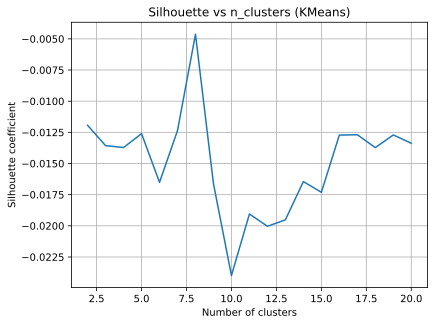

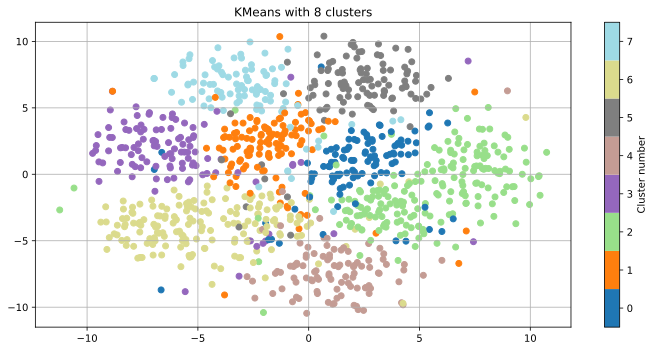

In [109]:
n_clusters_range = np.arange(2, 21)
silhouettes_kmeans = []
for n_clusters in n_clusters_range:
    kmeans_clusterer = KMeans(n_clusters=n_clusters)
    kmeans_labels = kmeans_clusterer.fit_predict(scaled_data)
    silhouette = silhouette_score(scaled_data, kmeans_labels)
    silhouettes_kmeans.append(silhouette)

# Plot silhouette scores for KMeans
plt.plot(n_clusters_range, silhouettes_kmeans)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette coefficient')
plt.title('Silhouette vs n_clusters (KMeans)')
plt.grid(True)
plt.show()

# Visualize clustering with optimal parameter for KMeans
optimal_n_clusters_kmeans = n_clusters_range[np.argmax(silhouettes_kmeans)]
kmeans_clusterer_optimal = KMeans(n_clusters=optimal_n_clusters_kmeans)
kmeans_labels_optimal = kmeans_clusterer_optimal.fit_predict(scaled_data)
plot_2d_data(lowd_data, kmeans_labels_optimal, title=f'KMeans with {optimal_n_clusters_kmeans} clusters',
             cmap='tab20')

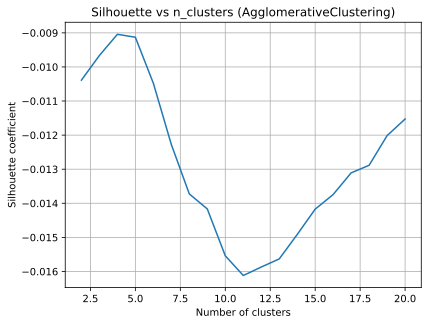

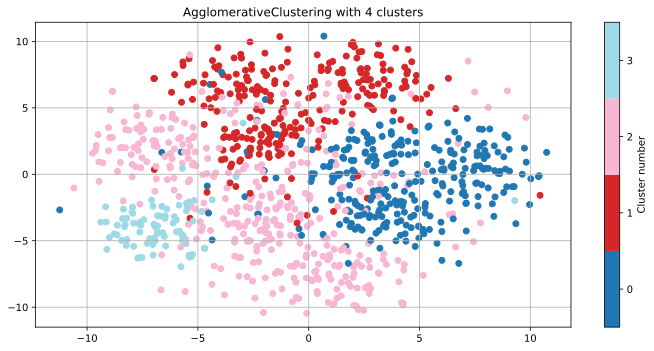

In [110]:
silhouettes_agglom = []
for n_clusters in n_clusters_range:
    agglom_clusterer = AgglomerativeClustering(n_clusters=n_clusters)
    agglom_labels = agglom_clusterer.fit_predict(scaled_data)
    silhouette = silhouette_score(scaled_data, agglom_labels)
    silhouettes_agglom.append(silhouette)

# Plot silhouette scores for AgglomerativeClustering
plt.plot(n_clusters_range, silhouettes_agglom)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette coefficient')
plt.title('Silhouette vs n_clusters (AgglomerativeClustering)')
plt.grid(True)
plt.show()

# Visualize clustering with optimal parameter for AgglomerativeClustering
optimal_n_clusters_agglom = n_clusters_range[np.argmax(silhouettes_agglom)]
agglom_clusterer_optimal = AgglomerativeClustering(n_clusters=optimal_n_clusters_agglom)
agglom_labels_optimal = agglom_clusterer_optimal.fit_predict(scaled_data)
plot_2d_data(lowd_data, agglom_labels_optimal, title=f'AgglomerativeClustering with {optimal_n_clusters_agglom} clusters',
             cmap='tab20')

For the KMeans and AgglomerativeClustering algorithms, the optimal number of clusters was successfully found — $10$, which corresponds to natural clustering. DBSCAN turned out to be unsuitable for this task and shows poor quality for any set of hyperparameters. When comparing algorithms with each other, it can be noted that KMeans actually produces better clustering since the optimal silhouette for this algorithm is better than for AgglomerativeClustering. However, it should be noted that using the silhouette to compare different algorithms should be done with caution, since for DBSCAN the silhouette with optimal parameters is significantly superior to the silhouette for the remaining algorithms despite significantly worse clustering.